In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, transform, color, filters, feature, restoration
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import tensorflow as tf
from sklearn.metrics import recall_score

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
keras.backend.clear_session()

In [57]:
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=15, shear_range=0.1, preprocessing_function=color.gray2rgb)
test_datagen = ImageDataGenerator(rescale=1./255,preprocessing_function=color.gray2rgb)
val_datagen = ImageDataGenerator(rescale=1./255,preprocessing_function=color.gray2rgb)

In [71]:
train_gen = train_datagen.flow_from_directory('data/train/', target_size=(224,224), batch_size=64)
test_gen = test_datagen.flow_from_directory('data/test/', target_size=(224,224), batch_size=64)
val_gen = val_datagen.flow_from_directory('data/val/', target_size=(224,224), batch_size=64)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [48]:
train_gen.labels

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [31]:
print(len(train_gen.labels))
print(sum(train_gen.labels))

5216
3875


In [28]:
def recall_m(y_test, y_pred):
    return recall_score(y_test, Y_pred)

In [5]:
def define_model(nb_filters, kernel_size, input_shape, pool_size):
    model = Sequential()  # model is a linear stack of layers (don't change)

    # note: the convolutional layers and dense layers require an activation function
    # see https://keras.io/activations/
    # and https://en.wikipedia.org/wiki/Activation_function
    # options: 'linear', 'sigmoid', 'tanh', 'relu', 'softplus', 'softsign'

    model.add(Conv2D(nb_filters,
                     (kernel_size[0], kernel_size[1]),
                     strides=(1,1),
                     padding='same',
                     input_shape=input_shape))  # first conv. layer  KEEP
    model.add(Activation('relu'))  # Activation specification necessary for Conv2D and Dense layers

    model.add(Conv2D(nb_filters*2,
                     (kernel_size[0], kernel_size[1]),
                     strides=(1,1),
                     padding='same'))  # 2nd conv. layer KEEP
    model.add(Activation('relu'))


    model.add(MaxPooling2D(pool_size=pool_size))  # decreases size, helps prevent overfitting
    model.add(Dropout(0.5))  # zeros out some fraction of inputs, helps prevent overfitting

    model.add(Flatten())  # necessary to flatten before going into conventional dense layer  KEEP
    print('Model flattened out to ', model.output_shape)

    # now start a typical neural network
    model.add(Dense(100))  # (only) 32 neurons in this layer, really?   KEEP
    model.add(Activation('relu'))

    model.add(Dropout(0.5))
    
    model.add(Dense(50))  # (only) 32 neurons in this layer, really?   KEEP
    model.add(Activation('relu'))

    model.add(Dropout(0.5))  # zeros out some fraction of inputs, helps prevent overfitting

    model.add(Dense(nb_classes))  # 10 final nodes (one for each class)  KEEP
    model.add(Activation('sigmoid'))  # softmax at end to pick between classes 0-9 KEEP

    # many optimizers available, see https://keras.io/optimizers/#usage-of-optimizers
    # suggest you KEEP loss at 'categorical_crossentropy' for this multiclass problem,
    # and KEEP metrics at 'accuracy'
    # suggest limiting optimizers to one of these: 'adam', 'adadelta', 'sgd'
    model.compile(loss='binary_crossentropy',
#                   optimizer=keras.optimizers.SGD(lr=0.05),
                  optimizer=keras.optimizers.Adam(learning_rate=0.01),
                  metrics=tf.keras.metrics.Recall())
    return model

In [6]:
batch_size = 5  # number of training samples used at a time to update the weights
nb_classes = 2    
nb_epoch = 10       # number of passes through the entire train dataset before weights "final"
img_rows, img_cols = 150,150   # the size of the MNIST images KEEP
input_shape = (img_rows, img_cols, 1)   # 1 channel image input (grayscale) KEEP
nb_filters = 64    # number of convolutional filters to use
pool_size = (2,2)  # pooling decreases image size, reduces computation, adds translational invariance
kernel_size = (5, 5)  # convolutional kernel size, slides over image to learn features


model = define_model(nb_filters, kernel_size, input_shape, pool_size)

Model flattened out to  (None, 720000)


In [24]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 150, 150, 64)      1664      
_________________________________________________________________
activation_12 (Activation)   (None, 150, 150, 64)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 150, 150, 128)     204928    
_________________________________________________________________
activation_13 (Activation)   (None, 150, 150, 128)     0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 75, 75, 128)       0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 75, 75, 128)       0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 720000)           

In [5]:
callbacks = [tf.keras.callbacks.TensorBoard(log_dir='logs',
                                 histogram_freq=0, 
                                 write_graph=True, 
                                 write_images=False,    
                                 update_freq='epoch', 
                                 profile_batch=2, 
                                 embeddings_freq=0,    
                                 embeddings_metadata=None)
#              tf.keras.callbacks.EarlyStopping(monitor='val_loss',
#                                              min_delta=0.05,
#                                              patience=3,
#                                              verbose=0,
#                                              mode='auto',
#                                              baseline=None,
#                                              restore_best_weights=False)
            ]

In [8]:
# during fit process watch train and test error simultaneously
model.fit(train_gen, epochs=nb_epoch,
          verbose=1, validation_data=(test_gen), callbacks=callbacks)

# score = model.evaluate(X_test, Y_test, verbose=0)
# print('Test score:', score[0])
# print('Test accuracy:', score[1])  # this is the one we care about

Epoch 1/10
  1/163 [..............................] - ETA: 0s - loss: 0.6967 - recall: 0.4062WARNING:tensorflow:From /home/rasputin1127/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
163/163 [==============================] - 47s 288ms/step - loss: 2.6241 - recall: 0.7337 - val_loss: 0.6724 - val_recall: 0.6250
Epoch 2/10
163/163 [==============================] - 46s 282ms/step - loss: 0.5740 - recall: 0.7429 - val_loss: 0.6826 - val_recall: 0.6250
Epoch 3/10
163/163 [==============================] - 46s 279ms/step - loss: 0.5731 - recall: 0.7429 - val_loss: 0.6897 - val_recall: 0.6250
Epoch 4/10
163/163 [==============================] - 44s 272ms/step - loss: 0.5707 - recall: 0.7429 - val_loss: 0.6923 - val_recall: 0.6250


In [5]:
play_img = io.imread("data/train/NORMAL/IM-0115-0001.jpeg")
play_img2 = io.imread("data/train/NORMAL/IM-0117-0001.jpeg")
pn_img = io.imread("data/train/PNEUMONIA/person1000_bacteria_2931.jpeg")

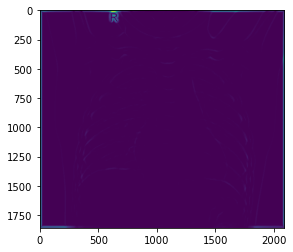

In [14]:
plt.imshow(filters.frangi(play_img))

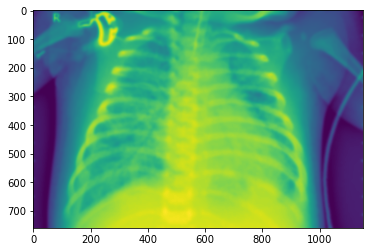

In [11]:
plt.imshow(filters.gaussian(pn_img,sigma=4))

In [30]:
play_img2.shape

(1152, 1422)

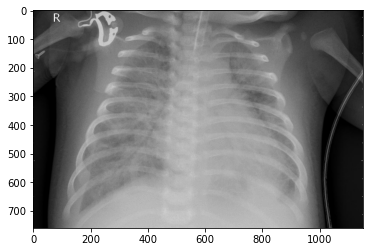

In [45]:
plt.imshow(pn_img, cmap='gray')

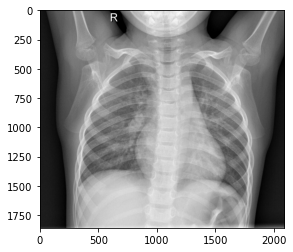

In [31]:
plt.imshow(play_img, cmap='gray')

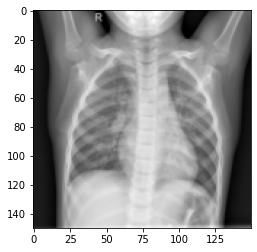

In [35]:
plt.imshow(transform.resize(play_img,(150,150)), cmap='gray')

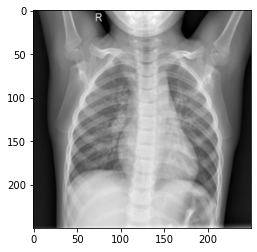

In [36]:
plt.imshow(transform.resize(play_img,(250,250)), cmap='gray')

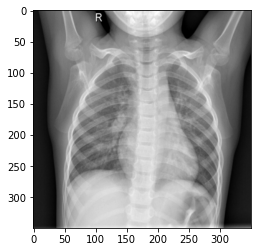

In [37]:
plt.imshow(transform.resize(play_img,(350,350)), cmap='gray')

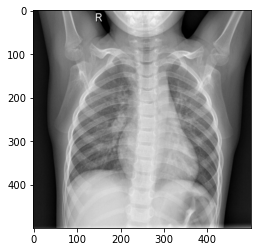

In [38]:
plt.imshow(transform.resize(play_img,(500,500)), cmap='gray')

In [40]:
test = color.gray2rgb(play_img)

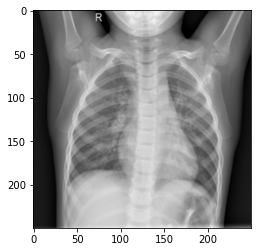

In [42]:
plt.imshow(transform.resize(test,(250,250)))

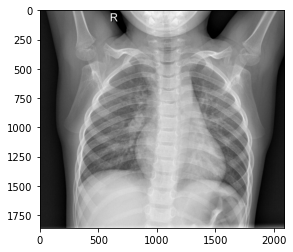

In [6]:
plt.imshow(test)

In [8]:
filenames = glob.glob('data/train/PNEUMONIA/*.jpeg')
len(filenames)

3875

In [21]:
def define_model2(nb_filters, kernel_size, input_shape, pool_size):
    model = Sequential()  # model is a linear stack of layers (don't change)

    # note: the convolutional layers and dense layers require an activation function
    # see https://keras.io/activations/
    # and https://en.wikipedia.org/wiki/Activation_function
    # options: 'linear', 'sigmoid', 'tanh', 'relu', 'softplus', 'softsign'

    model.add(Conv2D(nb_filters,
                     (kernel_size[0], kernel_size[1]),
                     strides=(1,1),
                     padding='same',
                     input_shape=input_shape))
    model.add(Activation(tf.keras.activations.swish))  

    model.add(Conv2D(nb_filters*2,
                     (kernel_size[0], kernel_size[1]),
                     strides=(1,1),
                     padding='same'))  
    model.add(Activation('relu'))


    model.add(MaxPooling2D(pool_size=pool_size))  # decreases size, helps prevent overfitting
    model.add(Dropout(0.5))  # zeros out some fraction of inputs, helps prevent overfitting

    model.add(Flatten())  # necessary to flatten before going into conventional dense layer  KEEP
    print('Model flattened out to ', model.output_shape)

    # now start a typical neural network
    model.add(Dense(100))  # (only) 32 neurons in this layer, really?   KEEP
    model.add(Activation('relu'))

    model.add(Dropout(0.5))
    
    model.add(Dense(50))  # (only) 32 neurons in this layer, really?   KEEP
    model.add(Activation('relu'))

    model.add(Dropout(0.5))  # zeros out some fraction of inputs, helps prevent overfitting

    model.add(Dense(nb_classes))  # 10 final nodes (one for each class)  KEEP
    model.add(Activation('sigmoid'))  # softmax at end to pick between classes 0-9 KEEP

    # many optimizers available, see https://keras.io/optimizers/#usage-of-optimizers
    # suggest you KEEP loss at 'categorical_crossentropy' for this multiclass problem,
    # and KEEP metrics at 'accuracy'
    # suggest limiting optimizers to one of these: 'adam', 'adadelta', 'sgd'
    model.compile(loss='binary_crossentropy',
#                   optimizer=keras.optimizers.SGD(lr=0.05),
                  optimizer=keras.optimizers.Adam(learning_rate=0.05),
                  metrics=tf.keras.metrics.Recall())
    return model 

In [22]:
batch_size = 5  # number of training samples used at a time to update the weights
nb_classes = 2    
nb_epoch = 10       # number of passes through the entire train dataset before weights "final"
img_rows, img_cols = 150,150   # the size of the MNIST images KEEP
input_shape = (img_rows, img_cols, 1)   # 1 channel image input (grayscale) KEEP
nb_filters = 64    # number of convolutional filters to use
pool_size = (2,2)  # pooling decreases image size, reduces computation, adds translational invariance
kernel_size = (5, 5)  # convolutional kernel size, slides over image to learn features


model2 = define_model2(nb_filters, kernel_size, input_shape, pool_size)

Model flattened out to  (None, 720000)


In [43]:
model2.fit(train_gen, epochs=nb_epoch,
          verbose=1, validation_data=(test_gen), callbacks=callbacks)

Epoch 1/10
163/163 [==============================] - 55s 336ms/step - loss: 616.6407 - recall_1: 0.7423 - val_loss: 0.6848 - val_recall_1: 0.6250
Epoch 2/10
163/163 [==============================] - 55s 335ms/step - loss: 0.5707 - recall_1: 0.7429 - val_loss: 0.7173 - val_recall_1: 0.6250
Epoch 3/10
163/163 [==============================] - 55s 337ms/step - loss: 0.5715 - recall_1: 0.7429 - val_loss: 0.6986 - val_recall_1: 0.6250
Epoch 4/10
163/163 [==============================] - 55s 337ms/step - loss: 0.5711 - recall_1: 0.7429 - val_loss: 0.6931 - val_recall_1: 0.6250


In [24]:
def define_model3(nb_filters, kernel_size, input_shape, pool_size):
    model = Sequential()  # model is a linear stack of layers (don't change)

    # note: the convolutional layers and dense layers require an activation function
    # see https://keras.io/activations/
    # and https://en.wikipedia.org/wiki/Activation_function
    # options: 'linear', 'sigmoid', 'tanh', 'relu', 'softplus', 'softsign'

    model.add(Conv2D(nb_filters,
                     (kernel_size[0], kernel_size[1]),
                     strides=(1,1),
                     padding='valid',
                     input_shape=input_shape))
    model.add(Activation(tf.keras.activations.swish))  

    model.add(Conv2D(nb_filters*2,
                     (kernel_size[0], kernel_size[1]),
                     strides=(1,1),
                     padding='valid'))  
    model.add(Activation('relu'))


    model.add(MaxPooling2D(pool_size=pool_size))  # decreases size, helps prevent overfitting
    model.add(Dropout(0.5))  # zeros out some fraction of inputs, helps prevent overfitting

    model.add(Flatten())  # necessary to flatten before going into conventional dense layer  KEEP
    print('Model flattened out to ', model.output_shape)

    # now start a typical neural network
    model.add(Dense(100))  # (only) 32 neurons in this layer, really?   KEEP
    model.add(Activation('relu'))

    model.add(Dropout(0.5))
    
    model.add(Dense(50))  # (only) 32 neurons in this layer, really?   KEEP
    model.add(Activation('relu'))

    model.add(Dropout(0.5))  # zeros out some fraction of inputs, helps prevent overfitting

    model.add(Dense(nb_classes))  # 10 final nodes (one for each class)  KEEP
    model.add(Activation('sigmoid'))  # softmax at end to pick between classes 0-9 KEEP

    # many optimizers available, see https://keras.io/optimizers/#usage-of-optimizers
    # suggest you KEEP loss at 'categorical_crossentropy' for this multiclass problem,
    # and KEEP metrics at 'accuracy'
    # suggest limiting optimizers to one of these: 'adam', 'adadelta', 'sgd'
    model.compile(loss='binary_crossentropy',
#                   optimizer=keras.optimizers.SGD(lr=0.05),
                  optimizer=keras.optimizers.Adam(learning_rate=0.05),
                  metrics=tf.keras.metrics.Recall())
    return model 

In [25]:
batch_size = 5  # number of training samples used at a time to update the weights
nb_classes = 2    
nb_epoch = 10       # number of passes through the entire train dataset before weights "final"
img_rows, img_cols = 150,150   # the size of the MNIST images KEEP
input_shape = (img_rows, img_cols, 1)   # 1 channel image input (grayscale) KEEP
nb_filters = 64    # number of convolutional filters to use
pool_size = (2,2)  # pooling decreases image size, reduces computation, adds translational invariance
kernel_size = (5, 5)  # convolutional kernel size, slides over image to learn features


model3 = define_model3(nb_filters, kernel_size, input_shape, pool_size)

Model flattened out to  (None, 645248)


In [46]:
model3.fit(train_gen, epochs=nb_epoch,
          verbose=1, validation_data=(test_gen), callbacks=callbacks)

Epoch 1/10
163/163 [==============================] - 47s 286ms/step - loss: 4342.5747 - recall_2: 0.7395 - val_loss: 0.7026 - val_recall_2: 0.6250
Epoch 2/10
163/163 [==============================] - 46s 282ms/step - loss: 0.5715 - recall_2: 0.7429 - val_loss: 0.7026 - val_recall_2: 0.6250
Epoch 3/10
163/163 [==============================] - 46s 283ms/step - loss: 0.5712 - recall_2: 0.7429 - val_loss: 0.6995 - val_recall_2: 0.6250
Epoch 4/10
163/163 [==============================] - 46s 284ms/step - loss: 0.5715 - recall_2: 0.7429 - val_loss: 0.7213 - val_recall_2: 0.6250


In [6]:
def define_model4(nb_filters, kernel_size, input_shape, pool_size):
    model = Sequential()  # model is a linear stack of layers (don't change)

    # note: the convolutional layers and dense layers require an activation function
    # see https://keras.io/activations/
    # and https://en.wikipedia.org/wiki/Activation_function
    # options: 'linear', 'sigmoid', 'tanh', 'relu', 'softplus', 'softsign'

    model.add(Conv2D(nb_filters,
                     (kernel_size[0], kernel_size[1]),
                     strides=(1,1),
                     padding='valid',
                     input_shape=input_shape))
    model.add(Activation(tf.keras.activations.swish))  

    model.add(Conv2D(nb_filters*2,
                     (kernel_size[0], kernel_size[1]),
                     strides=(1,1),
                     padding='valid'))  
    model.add(Activation(tf.keras.activations.swish))


    model.add(MaxPooling2D(pool_size=pool_size))  # decreases size, helps prevent overfitting
    model.add(Dropout(0.5))  # zeros out some fraction of inputs, helps prevent overfitting

    model.add(Flatten())  # necessary to flatten before going into conventional dense layer  KEEP
    print('Model flattened out to ', model.output_shape)

    # now start a typical neural network
    model.add(Dense(100))  # (only) 32 neurons in this layer, really?   KEEP
    model.add(Activation(tf.keras.activations.swish))

    model.add(Dropout(0.5))
    
    model.add(Dense(50))  # (only) 32 neurons in this layer, really?   KEEP
    model.add(Activation(tf.keras.activations.swish))

    model.add(Dropout(0.5))  # zeros out some fraction of inputs, helps prevent overfitting

    model.add(Dense(nb_classes))  # 10 final nodes (one for each class)  KEEP
    model.add(Activation('sigmoid'))  # softmax at end to pick between classes 0-9 KEEP

    # many optimizers available, see https://keras.io/optimizers/#usage-of-optimizers
    # suggest you KEEP loss at 'categorical_crossentropy' for this multiclass problem,
    # and KEEP metrics at 'accuracy'
    # suggest limiting optimizers to one of these: 'adam', 'adadelta', 'sgd'
    model.compile(loss='binary_crossentropy',
#                   optimizer=keras.optimizers.SGD(lr=0.05),
                  optimizer=keras.optimizers.Adam(learning_rate=0.05),
                  metrics=tf.keras.metrics.Recall())
    return model 

In [7]:
batch_size = 5  # number of training samples used at a time to update the weights
nb_classes = 2    
nb_epoch = 10       # number of passes through the entire train dataset before weights "final"
img_rows, img_cols = 150,150   # the size of the MNIST images KEEP
input_shape = (img_rows, img_cols, 1)   # 1 channel image input (grayscale) KEEP
nb_filters = 64    # number of convolutional filters to use
pool_size = (2,2)  # pooling decreases image size, reduces computation, adds translational invariance
kernel_size = (5, 5)  # convolutional kernel size, slides over image to learn features


model4 = define_model4(nb_filters, kernel_size, input_shape, pool_size)

Model flattened out to  (None, 645248)


In [8]:
model4.fit(train_gen, epochs=nb_epoch,
          verbose=1, validation_data=(test_gen), callbacks=callbacks)

Epoch 1/10
  1/163 [..............................] - ETA: 0s - loss: 0.6910 - recall: 0.6875WARNING:tensorflow:From /home/rasputin1127/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
163/163 [==============================] - 48s 292ms/step - loss: 13377.7744 - recall: 0.7333 - val_loss: 0.6839 - val_recall: 0.6250
Epoch 2/10
163/163 [==============================] - 46s 280ms/step - loss: 6.8579 - recall: 0.7425 - val_loss: 0.6946 - val_recall: 0.6250
Epoch 3/10
163/163 [==============================] - 46s 282ms/step - loss: 11.2738 - recall: 0.7423 - val_loss: 0.7038 - val_recall: 0.6250
Epoch 4/10
163/163 [==============================] - 46s 283ms/step - loss: 1.1478 - recall: 0.7429 - val_loss: 0.6983 - val_recall: 0.6250


In [13]:
def define_model5(nb_filters, kernel_size, input_shape, pool_size):
    model = Sequential()  # model is a linear stack of layers (don't change)

    # note: the convolutional layers and dense layers require an activation function
    # see https://keras.io/activations/
    # and https://en.wikipedia.org/wiki/Activation_function
    # options: 'linear', 'sigmoid', 'tanh', 'relu', 'softplus', 'softsign'

    model.add(Conv2D(nb_filters,
                     (kernel_size[0], kernel_size[1]),
                     strides=(1,1),
                     padding='valid',
                     input_shape=input_shape))
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(pool_size=pool_size))
    
    model.add(Conv2D(nb_filters*2,
                    (kernel_size[0], kernel_size[1]),
                    strides=(1,1),
                    padding='valid',
                    input_shape=input_shape))
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(pool_size=pool_size))
    
    model.add(Flatten())
    
    model.add(Dense(1000,activation='relu'))
    model.add(Dense(100,activation='relu'))
    
    model.add(Dense(nb_classes))
    model.add(Activation('sigmoid'))

    # many optimizers available, see https://keras.io/optimizers/#usage-of-optimizers
    # suggest you KEEP loss at 'categorical_crossentropy' for this multiclass problem,
    # and KEEP metrics at 'accuracy'
    # suggest limiting optimizers to one of these: 'adam', 'adadelta', 'sgd'
    model.compile(loss='categorical_crossentropy',
#                   optimizer=keras.optimizers.SGD(lr=0.05),
                  optimizer=keras.optimizers.Adam(learning_rate=0.001),
                  metrics=tf.keras.metrics.Recall())
    return model 

In [14]:
batch_size = 5  # number of training samples used at a time to update the weights
nb_classes = 2    
nb_epoch = 10       # number of passes through the entire train dataset before weights "final"
img_rows, img_cols = 150,150   # the size of the MNIST images KEEP
input_shape = (img_rows, img_cols, 1)   # 1 channel image input (grayscale) KEEP
nb_filters = 32    # number of convolutional filters to use
pool_size = (2,2)  # pooling decreases image size, reduces computation, adds translational invariance
kernel_size = (5, 5)  # convolutional kernel size, slides over image to learn features


model5 = define_model5(nb_filters, kernel_size, input_shape, pool_size)

In [15]:
model5.fit(train_gen, epochs=nb_epoch,
          verbose=1, validation_data=(test_gen), callbacks=callbacks)

Epoch 1/10
163/163 [==============================] - 43s 262ms/step - loss: 4.1326 - recall_2: 0.7433 - val_loss: 6.0443 - val_recall_2: 0.6250
Epoch 2/10
163/163 [==============================] - 42s 260ms/step - loss: 4.1439 - recall_2: 0.7429 - val_loss: 6.0443 - val_recall_2: 0.6250
Epoch 3/10
163/163 [==============================] - 42s 260ms/step - loss: 4.1439 - recall_2: 0.7429 - val_loss: 6.0443 - val_recall_2: 0.6250
Epoch 4/10
163/163 [==============================] - 42s 259ms/step - loss: 4.1439 - recall_2: 0.7429 - val_loss: 6.0443 - val_recall_2: 0.6250


In [16]:
model5.predict(test_gen)

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [17]:
model5.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 146, 146, 32)      832       
_________________________________________________________________
activation_8 (Activation)    (None, 146, 146, 32)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 69, 69, 64)        51264     
_________________________________________________________________
activation_9 (Activation)    (None, 69, 69, 64)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 34, 34, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 73984)            

In [7]:
def define_model6(nb_filters, kernel_size, input_shape, pool_size):
    model = Sequential()  # model is a linear stack of layers (don't change)

    # note: the convolutional layers and dense layers require an activation function
    # see https://keras.io/activations/
    # and https://en.wikipedia.org/wiki/Activation_function
    # options: 'linear', 'sigmoid', 'tanh', 'relu', 'softplus', 'softsign'

    model.add(Conv2D(nb_filters,
                     (kernel_size[0], kernel_size[1]),
                     strides=(1,1),
                     padding='valid',
                     input_shape=input_shape))
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(pool_size=pool_size))
    
    model.add(Conv2D(nb_filters,
                    (kernel_size[0], kernel_size[1]),
                    strides=(1,1),
                    padding='valid',
                    input_shape=input_shape))
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(pool_size=pool_size))
    
    model.add(Flatten())
    
    model.add(Dense(100,activation='relu'))
    
    model.add(Dense(nb_classes))
    model.add(Activation('sigmoid'))

    # many optimizers available, see https://keras.io/optimizers/#usage-of-optimizers
    # suggest you KEEP loss at 'categorical_crossentropy' for this multiclass problem,
    # and KEEP metrics at 'accuracy'
    # suggest limiting optimizers to one of these: 'adam', 'adadelta', 'sgd'
    model.compile(loss='categorical_crossentropy',
#                   optimizer=keras.optimizers.SGD(lr=0.05),
                  optimizer=keras.optimizers.Adam(learning_rate=0.001),
                  metrics=tf.keras.metrics.Recall())
    return model 

In [6]:
batch_size = 5  # number of training samples used at a time to update the weights
nb_classes = 2    
nb_epoch = 10       # number of passes through the entire train dataset before weights "final"
img_rows, img_cols = 150,150   # the size of the MNIST images KEEP
input_shape = (img_rows, img_cols, 1)   # 1 channel image input (grayscale) KEEP
nb_filters = 32    # number of convolutional filters to use
pool_size = (2,2)  # pooling decreases image size, reduces computation, adds translational invariance
kernel_size = (5, 5)  # convolutional kernel size, slides over image to learn features

In [10]:
model6 = define_model6(nb_filters, kernel_size, input_shape, pool_size)

In [11]:
model6.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 246, 246, 32)      832       
_________________________________________________________________
activation (Activation)      (None, 246, 246, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 123, 123, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 119, 119, 32)      25632     
_________________________________________________________________
activation_1 (Activation)    (None, 119, 119, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 59, 59, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 111392)            0

In [24]:
model6.fit(train_gen, epochs=nb_epoch,
          verbose=1, validation_data=(test_gen), callbacks=callbacks)

Epoch 1/10
163/163 [==============================] - 45s 274ms/step - loss: 0.3345 - recall_3: 0.9488 - val_loss: 0.8407 - val_recall_3: 0.8109
Epoch 2/10
163/163 [==============================] - 44s 269ms/step - loss: 0.2637 - recall_3: 0.9820 - val_loss: 1.6570 - val_recall_3: 0.6971
Epoch 3/10
163/163 [==============================] - 43s 261ms/step - loss: 0.2429 - recall_3: 0.9862 - val_loss: 1.0399 - val_recall_3: 0.7837
Epoch 4/10
163/163 [==============================] - 42s 257ms/step - loss: 0.2204 - recall_3: 0.9921 - val_loss: 0.7531 - val_recall_3: 0.8494
Epoch 5/10
163/163 [==============================] - 42s 257ms/step - loss: 0.2276 - recall_3: 0.9910 - val_loss: 1.0968 - val_recall_3: 0.8077
Epoch 6/10
163/163 [==============================] - 42s 259ms/step - loss: 0.1279 - recall_3: 0.7178 - val_loss: 0.9456 - val_recall_3: 0.5545
Epoch 7/10
163/163 [==============================] - 42s 256ms/step - loss: 0.0720 - recall_3: 0.6202 - val_loss: 0.9057 - val_re

In [7]:
def define_model7(nb_filters, kernel_size, input_shape, pool_size):
    model = Sequential()  # model is a linear stack of layers (don't change)

    # note: the convolutional layers and dense layers require an activation function
    # see https://keras.io/activations/
    # and https://en.wikipedia.org/wiki/Activation_function
    # options: 'linear', 'sigmoid', 'tanh', 'relu', 'softplus', 'softsign'

    model.add(keras.layers.BatchNormalization())
    
    model.add(Conv2D(nb_filters,
                     (7, 7),
                     strides=(1,1),
                     padding='valid',
                     input_shape=input_shape))
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(pool_size=pool_size))
    
    model.add(keras.layers.BatchNormalization())
    
    model.add(Conv2D(nb_filters,
                    (kernel_size[0], kernel_size[1]),
                    strides=(1,1),
                    padding='valid',
                    input_shape=input_shape))
    model.add(Activation('relu'))

    model.add(MaxPooling2D(pool_size=pool_size))

    model.add(keras.layers.BatchNormalization())
    
    model.add(Conv2D(nb_filters,
                     (3, 3),
                     strides=(5,5),
                     padding='same',
                     input_shape=input_shape))
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(pool_size=pool_size))
    
    model.add(Flatten())
    
    model.add(keras.layers.BatchNormalization())
    
    model.add(Dense(100,activation='selu',kernel_initializer='lecun_normal'))
    
    model.add(Dense(nb_classes))
    model.add(Activation('sigmoid'))

    # many optimizers available, see https://keras.io/optimizers/#usage-of-optimizers
    # suggest you KEEP loss at 'categorical_crossentropy' for this multiclass problem,
    # and KEEP metrics at 'accuracy'
    # suggest limiting optimizers to one of these: 'adam', 'adadelta', 'sgd'
    model.compile(loss='categorical_crossentropy',
#                   optimizer=keras.optimizers.SGD(lr=0.05),
                  optimizer=keras.optimizers.Adam(learning_rate=0.001),
                  metrics=[tf.keras.metrics.Recall(),'accuracy'])
    return model 

In [8]:
model7 = define_model7(nb_filters, kernel_size, input_shape, pool_size)

In [10]:
model7.summary()

ValueError: You must provide an `input_shape` argument.

In [53]:
model7.compile(loss='categorical_crossentropy',
#                   optimizer=keras.optimizers.SGD(lr=0.05),
                  optimizer=keras.optimizers.Adam(learning_rate=0.01),
                  metrics=[tf.keras.metrics.Recall(),'accuracy'])

In [11]:
model7.fit(train_gen, epochs=20,
          verbose=1, validation_data=(test_gen), class_weight={0:1.945,1:0.673})

Epoch 1/20
163/163 [==============================] - 51s 314ms/step - loss: 0.2312 - recall: 0.8662 - accuracy: 0.8861 - val_loss: 4.1771 - val_recall: 0.6250 - val_accuracy: 0.6250
Epoch 2/20
163/163 [==============================] - 49s 300ms/step - loss: 0.1755 - recall: 0.9143 - accuracy: 0.9268 - val_loss: 1.9236 - val_recall: 0.6250 - val_accuracy: 0.6346
Epoch 3/20
163/163 [==============================] - 48s 296ms/step - loss: 0.1715 - recall: 0.9296 - accuracy: 0.9256 - val_loss: 1.3631 - val_recall: 0.6955 - val_accuracy: 0.7212
Epoch 4/20
163/163 [==============================] - 47s 291ms/step - loss: 0.1480 - recall: 0.9421 - accuracy: 0.9362 - val_loss: 0.5087 - val_recall: 0.8558 - val_accuracy: 0.7644
Epoch 5/20
163/163 [==============================] - 47s 291ms/step - loss: 0.1170 - recall: 0.9571 - accuracy: 0.9488 - val_loss: 0.5097 - val_recall: 0.8638 - val_accuracy: 0.8173
Epoch 6/20
163/163 [==============================] - 47s 290ms/step - loss: 0.1280 -

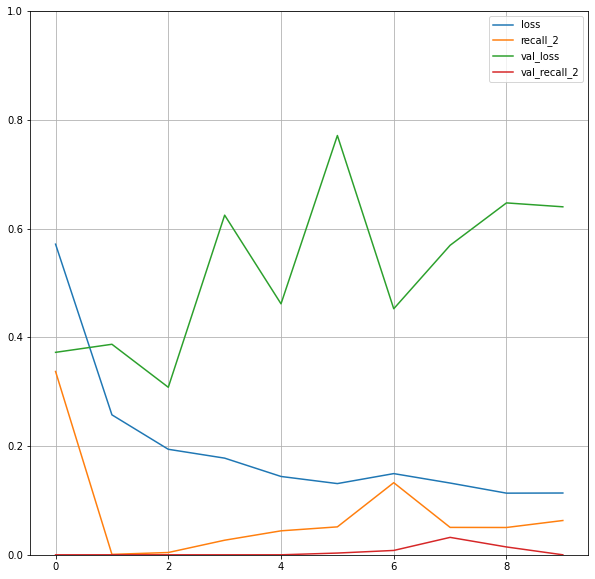

In [38]:
pd.DataFrame(model7.history.history).plot(figsize=(10,10))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show();

In [15]:
model7.predict(test_gen)[:50]

array([[3.88366245e-02, 9.85210359e-01],
       [9.90193546e-01, 6.05298162e-01],
       [9.40279126e-01, 8.77357945e-02],
       [9.21115696e-01, 6.07133746e-01],
       [9.99999523e-01, 1.06375286e-04],
       [3.00670322e-03, 9.92081523e-01],
       [1.39261492e-05, 9.99890685e-01],
       [9.77992594e-01, 1.17810639e-02],
       [5.43974433e-03, 9.95888889e-01],
       [8.92596290e-06, 9.98223364e-01],
       [4.72147554e-01, 9.33639884e-01],
       [3.48360627e-03, 9.92739022e-01],
       [9.99597847e-01, 1.51433327e-04],
       [9.11338866e-01, 2.01163813e-01],
       [9.97781694e-01, 1.76113993e-02],
       [2.59573781e-03, 9.95324314e-01],
       [4.80571277e-02, 7.80071616e-01],
       [2.72229109e-02, 9.57649112e-01],
       [9.40554380e-01, 2.27172911e-01],
       [1.75415203e-02, 9.90824223e-01],
       [3.82904436e-05, 9.99989033e-01],
       [9.99900699e-01, 2.70499004e-04],
       [4.21773293e-05, 9.99533772e-01],
       [9.99739110e-01, 1.73895282e-03],
       [9.947377

In [16]:
score = model7.evaluate(val_gen, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])  # this is the one we care about

Test score: 0.3431639075279236
Test accuracy: 0.875


In [17]:
score

[0.3431639075279236, 0.875, 0.875]

In [18]:
model7.metrics_names

['loss', 'recall', 'accuracy']

In [14]:
def define_model8(nb_filters, kernel_size, input_shape, pool_size):
    model = Sequential()  # model is a linear stack of layers (don't change)

    # note: the convolutional layers and dense layers require an activation function
    # see https://keras.io/activations/
    # and https://en.wikipedia.org/wiki/Activation_function
    # options: 'linear', 'sigmoid', 'tanh', 'relu', 'softplus', 'softsign'

    model.add(keras.layers.BatchNormalization())
    
    model.add(Conv2D(nb_filters,
                     (7, 7),
                     strides=(1,1),
                     padding='same',
                     input_shape=input_shape,
                     activation='selu',
                     kernel_initializer='lecun_normal',
                     kernel_regularizer=keras.regularizers.l2(0.01)))
    
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(0.5))
    
    model.add(keras.layers.BatchNormalization())
    
    model.add(Conv2D(nb_filters,
                    (kernel_size[0], kernel_size[1]),
                    strides=(1,1),
                    padding='same',
                    input_shape=input_shape,
                    activation='selu',
                    kernel_initializer='lecun_normal',
                    kernel_regularizer=keras.regularizers.l2(0.01)))

    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(0.5))

    model.add(keras.layers.BatchNormalization())
    
    model.add(Conv2D(nb_filters,
                     (3, 3),
                     strides=(5,5),
                     padding='same',
                     input_shape=input_shape,
                     activation='selu',
                     kernel_initializer='lecun_normal',
                     kernel_regularizer=keras.regularizers.l2(0.01)))
    
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    
    model.add(keras.layers.BatchNormalization())
    
    model.add(Dense(100,activation='selu',kernel_initializer='lecun_normal'))
    model.add(Dropout(0.5))
    
    model.add(Dense(nb_classes))
    model.add(Activation('sigmoid'))

    # many optimizers available, see https://keras.io/optimizers/#usage-of-optimizers
    # suggest you KEEP loss at 'categorical_crossentropy' for this multiclass problem,
    # and KEEP metrics at 'accuracy'
    # suggest limiting optimizers to one of these: 'adam', 'adadelta', 'sgd'
    model.compile(loss='categorical_crossentropy',
#                   optimizer=keras.optimizers.SGD(lr=0.05),
                  optimizer=keras.optimizers.Adam(learning_rate=0.001),
                  metrics=[tf.keras.metrics.Recall(),'accuracy'])
    return model 

In [15]:
model8 = define_model8(nb_filters, kernel_size, input_shape, pool_size)

In [16]:
model8.fit(train_gen, epochs=20,
          verbose=1, validation_data=(test_gen), class_weight={0:1.945,1:0.673})

Epoch 1/20
163/163 [==============================] - 48s 295ms/step - loss: 1.3511 - recall_1: 0.7636 - accuracy: 0.7535 - val_loss: 4.6926 - val_recall_1: 0.6250 - val_accuracy: 0.6250
Epoch 2/20
163/163 [==============================] - 48s 292ms/step - loss: 0.9700 - recall_1: 0.8760 - accuracy: 0.8507 - val_loss: 2.2831 - val_recall_1: 0.6587 - val_accuracy: 0.6619
Epoch 3/20
163/163 [==============================] - 47s 291ms/step - loss: 0.7807 - recall_1: 0.9011 - accuracy: 0.8679 - val_loss: 1.1972 - val_recall_1: 0.7869 - val_accuracy: 0.7901
Epoch 4/20
163/163 [==============================] - 47s 290ms/step - loss: 0.6278 - recall_1: 0.9093 - accuracy: 0.8848 - val_loss: 0.8002 - val_recall_1: 0.8494 - val_accuracy: 0.8734
Epoch 5/20
163/163 [==============================] - 47s 290ms/step - loss: 0.5532 - recall_1: 0.9187 - accuracy: 0.8896 - val_loss: 0.6287 - val_recall_1: 0.8814 - val_accuracy: 0.8542
Epoch 6/20
163/163 [==============================] - 47s 291ms/s

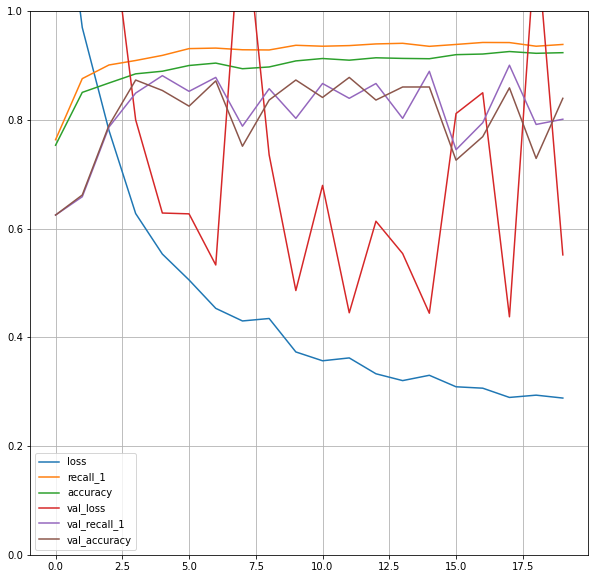

In [17]:
pd.DataFrame(model8.history.history).plot(figsize=(10,10))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show();

In [23]:
def define_model9(nb_filters, kernel_size, input_shape, pool_size):
    model = Sequential()  # model is a linear stack of layers (don't change)

    # note: the convolutional layers and dense layers require an activation function
    # see https://keras.io/activations/
    # and https://en.wikipedia.org/wiki/Activation_function
    # options: 'linear', 'sigmoid', 'tanh', 'relu', 'softplus', 'softsign'

    model.add(keras.layers.BatchNormalization())
    
    model.add(Conv2D(nb_filters,
                     (7, 7),
                     strides=(1,1),
                     padding='same',
                     input_shape=input_shape,
                     activation='selu',
                     kernel_initializer='lecun_normal',
                     kernel_regularizer=keras.regularizers.l2(0.01)))
    
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(0.5))
    
    model.add(keras.layers.BatchNormalization())

    model.add(Conv2D(nb_filters,
                     (7, 7),
                     strides=(1,1),
                     padding='same',
                     input_shape=input_shape,
                     activation='selu',
                     kernel_initializer='lecun_normal',
                     kernel_regularizer=keras.regularizers.l2(0.01)))
    
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(0.5))
    
    model.add(keras.layers.BatchNormalization())
    
    model.add(Conv2D(nb_filters,
                    (kernel_size[0], kernel_size[1]),
                    strides=(1,1),
                    padding='same',
                    input_shape=input_shape,
                    activation='selu',
                    kernel_initializer='lecun_normal',
                    kernel_regularizer=keras.regularizers.l2(0.01)))

    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(0.5))

    model.add(keras.layers.BatchNormalization())
    
    model.add(Conv2D(nb_filters,
                    (kernel_size[0], kernel_size[1]),
                    strides=(1,1),
                    padding='same',
                    input_shape=input_shape,
                    activation='selu',
                    kernel_initializer='lecun_normal',
                    kernel_regularizer=keras.regularizers.l2(0.01)))

    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(0.5))

    model.add(keras.layers.BatchNormalization())
    
    model.add(Conv2D(nb_filters,
                     (3, 3),
                     strides=(1,1),
                     padding='same',
                     input_shape=input_shape,
                     activation='selu',
                     kernel_initializer='lecun_normal',
                     kernel_regularizer=keras.regularizers.l2(0.01)))
    
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(0.5))

    model.add(keras.layers.BatchNormalization())
    
#     model.add(Conv2D(nb_filters,
#                      (3, 3),
#                      strides=(3,3),
#                      padding='same',
#                      input_shape=input_shape,
#                      activation='selu',
#                      kernel_initializer='lecun_normal',
#                      kernel_regularizer=keras.regularizers.l2(0.01)))
    
#     model.add(MaxPooling2D(pool_size=pool_size))
#     model.add(Dropout(0.5))
    
    model.add(Flatten())
    
    model.add(keras.layers.BatchNormalization())
    
    model.add(Dense(250,activation='selu',kernel_initializer='lecun_normal'))
    model.add(Dropout(0.5))
    
    model.add(Dense(nb_classes))
    model.add(Activation('sigmoid'))

    # many optimizers available, see https://keras.io/optimizers/#usage-of-optimizers
    # suggest you KEEP loss at 'categorical_crossentropy' for this multiclass problem,
    # and KEEP metrics at 'accuracy'
    # suggest limiting optimizers to one of these: 'adam', 'adadelta', 'sgd'
    model.compile(loss='categorical_crossentropy',
#                   optimizer=keras.optimizers.SGD(lr=0.05),
                  optimizer=keras.optimizers.SGD(momentum=0.9,nesterov=True,learning_rate=0.001),
                  metrics=[tf.keras.metrics.Recall(),'accuracy'])
    return model 

In [24]:
model9 = define_model9(nb_filters, kernel_size, input_shape, pool_size)

In [36]:
model9.fit(train_gen, epochs=80,
          verbose=1, validation_data=(test_gen), class_weight={0:1.945,1:0.673})

Epoch 1/80
163/163 [==============================] - 100s 614ms/step - loss: 0.6749 - recall_2: 0.8963 - accuracy: 0.8854 - val_loss: 3.2543 - val_recall_2: 0.6250 - val_accuracy: 0.6250
Epoch 2/80
163/163 [==============================] - 99s 605ms/step - loss: 0.6398 - recall_2: 0.9034 - accuracy: 0.8942 - val_loss: 3.5807 - val_recall_2: 0.6250 - val_accuracy: 0.6250
Epoch 3/80
163/163 [==============================] - 98s 604ms/step - loss: 0.6149 - recall_2: 0.9016 - accuracy: 0.8924 - val_loss: 1.7341 - val_recall_2: 0.6875 - val_accuracy: 0.6827
Epoch 4/80
163/163 [==============================] - 99s 605ms/step - loss: 0.5753 - recall_2: 0.9080 - accuracy: 0.8978 - val_loss: 2.8866 - val_recall_2: 0.6250 - val_accuracy: 0.6250
Epoch 5/80
163/163 [==============================] - 98s 604ms/step - loss: 0.5672 - recall_2: 0.9114 - accuracy: 0.8995 - val_loss: 2.2765 - val_recall_2: 0.6458 - val_accuracy: 0.6458
Epoch 6/80
163/163 [==============================] - 97s 594ms/

KeyboardInterrupt: 

In [14]:
score = dense.evaluate(val_gen, verbose=0)
print('Test score:', score[0])
print('Test recall:', score[1])
print('Test accuracy:', score[2])

Test score: 0.7697722911834717
Test recall: 0.6875
Test accuracy: 0.6875


In [15]:
pd.DataFrame(dense.history.history).plot(figsize=(10,10))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show();

TypeError: no numeric data to plot

In [22]:
nb_classes = 2    
img_rows, img_cols = 250,250   # the size of the MNIST images KEEP
input_shape = (img_rows, img_cols, 1)   # 1 channel image input (grayscale) KEEP
nb_filters = 32    # number of convolutional filters to use
pool_size = (3,3)  # pooling decreases image size, reduces computation, adds translational invariance
kernel_size = (5, 5)  # convolutional kernel size, slides over image to learn features

In [37]:
model9.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_14 (Batc (None, None, None, 1)     4         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, None, None, 32)    1600      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, None, None, 32)    0         
_________________________________________________________________
dropout_12 (Dropout)         (None, None, None, 32)    0         
_________________________________________________________________
batch_normalization_15 (Batc (None, None, None, 32)    128       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, None, None, 32)    50208     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, None, None, 32)   

In [41]:
def define_model10(nb_filters, kernel_size, input_shape, pool_size):
    model = Sequential()  # model is a linear stack of layers (don't change)

    # note: the convolutional layers and dense layers require an activation function
    # see https://keras.io/activations/
    # and https://en.wikipedia.org/wiki/Activation_function
    # options: 'linear', 'sigmoid', 'tanh', 'relu', 'softplus', 'softsign'
    
    model.add(Conv2D(nb_filters,
                     (7, 7),
                     strides=(1,1),
                     padding='same',
                     input_shape=input_shape,
                     kernel_initializer='he_normal',
                     kernel_regularizer=keras.regularizers.l2(0.01)))
    model.add(keras.layers.LeakyReLU(alpha=0.2))
    
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(0.5))
    
    model.add(keras.layers.BatchNormalization())

    model.add(Conv2D(nb_filters,
                     (7, 7),
                     strides=(1,1),
                     padding='same',
                     input_shape=input_shape,
                     kernel_initializer='he_normal',
                     kernel_regularizer=keras.regularizers.l2(0.01)))
    model.add(keras.layers.LeakyReLU(alpha=0.2))
    
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(0.5))
    
    model.add(keras.layers.BatchNormalization())
    
    model.add(Conv2D(nb_filters,
                    (kernel_size[0], kernel_size[1]),
                    strides=(1,1),
                    padding='same',
                    input_shape=input_shape,
                    kernel_initializer='he_normal',
                    kernel_regularizer=keras.regularizers.l2(0.01)))
    model.add(keras.layers.LeakyReLU(alpha=0.2))
    
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(0.5))

    model.add(keras.layers.BatchNormalization())
    
    model.add(Conv2D(nb_filters,
                    (kernel_size[0], kernel_size[1]),
                    strides=(1,1),
                    padding='same',
                    input_shape=input_shape,
                    kernel_initializer='he_normal',
                    kernel_regularizer=keras.regularizers.l2(0.01)))
    model.add(keras.layers.LeakyReLU(alpha=0.2))
    
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(0.5))

    model.add(keras.layers.BatchNormalization())
    
    model.add(Conv2D(nb_filters,
                     (3, 3),
                     strides=(1,1),
                     padding='same',
                     input_shape=input_shape,
                     kernel_initializer='he_normal',
                     kernel_regularizer=keras.regularizers.l2(0.01)))
    model.add(keras.layers.LeakyReLU(alpha=0.2))
    
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(0.5))

    model.add(keras.layers.BatchNormalization())
    
#     model.add(Conv2D(nb_filters,
#                      (3, 3),
#                      strides=(3,3),
#                      padding='same',
#                      input_shape=input_shape,
#                      activation='selu',
#                      kernel_initializer='lecun_normal',
#                      kernel_regularizer=keras.regularizers.l2(0.01)))
    
#     model.add(MaxPooling2D(pool_size=pool_size))
#     model.add(Dropout(0.5))
    
    model.add(Flatten())
    
    model.add(keras.layers.BatchNormalization())
    
    model.add(Dense(250,kernel_initializer='he_normal'))
    model.add(keras.layers.LeakyReLU(alpha=0.2))
    model.add(Dropout(0.5))
    
    model.add(Dense(nb_classes))
    model.add(Activation('sigmoid'))

    # many optimizers available, see https://keras.io/optimizers/#usage-of-optimizers
    # suggest you KEEP loss at 'categorical_crossentropy' for this multiclass problem,
    # and KEEP metrics at 'accuracy'
    # suggest limiting optimizers to one of these: 'adam', 'adadelta', 'sgd'
    model.compile(loss='categorical_crossentropy',
#                   optimizer=keras.optimizers.SGD(lr=0.05),
                  optimizer=keras.optimizers.SGD(momentum=0.9,nesterov=True,learning_rate=0.001),
                  metrics=[tf.keras.metrics.Recall(),'accuracy'])
    return model 

In [42]:
model10 = define_model10(nb_filters=nb_filters, kernel_size=kernel_size, input_shape=input_shape, pool_size=pool_size)

In [43]:
model10.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 250, 250, 32)      1600      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 250, 250, 32)      0         
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 83, 83, 32)        0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 83, 83, 32)        0         
_________________________________________________________________
batch_normalization_27 (Batc (None, 83, 83, 32)        128       
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 83, 83, 32)        50208     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 83, 83, 32)       

In [ ]:
model10.fit(train_gen, epochs=50,
          verbose=1, validation_data=(test_gen), class_weight={0:1.945,1:0.673})

Epoch 1/50
163/163 [==============================] - 103s 632ms/step - loss: 3.8806 - recall_4: 0.8576 - accuracy: 0.4749 - val_loss: 3.7221 - val_recall_4: 1.0000 - val_accuracy: 0.6250
Epoch 2/50
163/163 [==============================] - 104s 636ms/step - loss: 3.6480 - recall_4: 0.9609 - accuracy: 0.4918 - val_loss: 3.5302 - val_recall_4: 1.0000 - val_accuracy: 0.6250
Epoch 3/50
163/163 [==============================] - 103s 635ms/step - loss: 3.4516 - recall_4: 0.9845 - accuracy: 0.4942 - val_loss: 3.3490 - val_recall_4: 1.0000 - val_accuracy: 0.6250
Epoch 4/50
163/163 [==============================] - 101s 617ms/step - loss: 3.2766 - recall_4: 0.9881 - accuracy: 0.5111 - val_loss: 3.1804 - val_recall_4: 1.0000 - val_accuracy: 0.6250
Epoch 5/50
163/163 [==============================] - 102s 627ms/step - loss: 3.1129 - recall_4: 0.9898 - accuracy: 0.5063 - val_loss: 3.0212 - val_recall_4: 1.0000 - val_accuracy: 0.6250
Epoch 6/50
163/163 [==============================] - 112s 6

In [9]:
def create_selu_layer(model,neurons):
    model.add(Dense(neurons, activation='selu', kernel_initializer='lecun_normal', kernel_regularizer=keras.regularizers.l2()))
    return model              

In [16]:
def define_dense_model(layers=5, neurons=30):
    model = Sequential()  # model is a linear stack of layers (don't change)

    model.add(Flatten())
    
    for i in range(layers):
        create_selu_layer(model, neurons)
        model.add(keras.layers.BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(2))
    model.add(Activation('sigmoid'))
    
    model.compile(loss='categorical_crossentropy',
#                   optimizer=keras.optimizers.SGD(lr=0.05),
                  optimizer=keras.optimizers.Adam(learning_rate=0.005),
                  metrics=[tf.keras.metrics.Recall(),'accuracy'])
    return model 

In [11]:
dense = define_dense_model(layers=10)

In [13]:
dense.fit(train_gen, epochs=50,
          verbose=1, validation_data=(test_gen), class_weight={0:1.945,1:0.673})

Epoch 1/50
163/163 [==============================] - 90s 550ms/step - loss: 3.7416 - recall: 0.5521 - accuracy: 0.5474 - val_loss: 3.6467 - val_recall: 0.6026 - val_accuracy: 0.4487
Epoch 2/50
163/163 [==============================] - 86s 529ms/step - loss: 3.4496 - recall: 0.6177 - accuracy: 0.6250 - val_loss: 3.1505 - val_recall: 0.8766 - val_accuracy: 0.8061
Epoch 3/50
163/163 [==============================] - 85s 522ms/step - loss: 3.1752 - recall: 0.6967 - accuracy: 0.7084 - val_loss: 3.0039 - val_recall: 0.8061 - val_accuracy: 0.7949
Epoch 4/50
163/163 [==============================] - 86s 526ms/step - loss: 2.9307 - recall: 0.7485 - accuracy: 0.7554 - val_loss: 2.8941 - val_recall: 0.8141 - val_accuracy: 0.8045
Epoch 5/50
163/163 [==============================] - 86s 528ms/step - loss: 2.7173 - recall: 0.7860 - accuracy: 0.7960 - val_loss: 2.6664 - val_recall: 0.8349 - val_accuracy: 0.8301
Epoch 6/50
163/163 [==============================] - 86s 527ms/step - loss: 2.5719 -

In [17]:
dense2 = define_dense_model(layers=10)

In [18]:
dense2.fit(train_gen, epochs=50,
          verbose=1, validation_data=(test_gen), class_weight={0:1.945,1:0.673})

Epoch 1/50
163/163 [==============================] - 81s 500ms/step - loss: 3.3809 - recall_1: 0.7377 - accuracy: 0.7571 - val_loss: 2.9339 - val_recall_1: 0.9631 - val_accuracy: 0.7596
Epoch 2/50
163/163 [==============================] - 81s 495ms/step - loss: 2.2862 - recall_1: 0.8390 - accuracy: 0.8484 - val_loss: 2.1576 - val_recall_1: 0.9696 - val_accuracy: 0.8045
Epoch 3/50
163/163 [==============================] - 81s 495ms/step - loss: 1.6814 - recall_1: 0.8777 - accuracy: 0.8727 - val_loss: 1.7903 - val_recall_1: 0.9984 - val_accuracy: 0.7564
Epoch 4/50
163/163 [==============================] - 81s 494ms/step - loss: 1.4063 - recall_1: 0.8677 - accuracy: 0.8526 - val_loss: 2.5706 - val_recall_1: 0.6250 - val_accuracy: 0.6250
Epoch 5/50
163/163 [==============================] - 81s 496ms/step - loss: 1.1295 - recall_1: 0.8794 - accuracy: 0.8708 - val_loss: 2.2813 - val_recall_1: 0.6250 - val_accuracy: 0.6250
Epoch 6/50
163/163 [==============================] - 81s 494ms/s

Epoch 45/50
163/163 [==============================] - 81s 495ms/step - loss: 0.3603 - recall_1: 0.8808 - accuracy: 0.9059 - val_loss: 2.4321 - val_recall_1: 0.3782 - val_accuracy: 0.3846
Epoch 46/50
163/163 [==============================] - 80s 493ms/step - loss: 0.3891 - recall_1: 0.8712 - accuracy: 0.8917 - val_loss: 2.3764 - val_recall_1: 0.5321 - val_accuracy: 0.5417
Epoch 47/50
163/163 [==============================] - 80s 493ms/step - loss: 0.3780 - recall_1: 0.8694 - accuracy: 0.8967 - val_loss: 0.7910 - val_recall_1: 0.6538 - val_accuracy: 0.6747
Epoch 48/50
163/163 [==============================] - 80s 492ms/step - loss: 0.3552 - recall_1: 0.8669 - accuracy: 0.8993 - val_loss: 1.1502 - val_recall_1: 0.6250 - val_accuracy: 0.6266
Epoch 49/50
163/163 [==============================] - 80s 492ms/step - loss: 0.3565 - recall_1: 0.8742 - accuracy: 0.9061 - val_loss: 3.5346 - val_recall_1: 0.6458 - val_accuracy: 0.6490
Epoch 50/50
163/163 [==============================] - 81s 4

In [19]:
dense2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, None)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 30)                1875030   
_________________________________________________________________
batch_normalization_10 (Batc (None, 30)                120       
_________________________________________________________________
dense_12 (Dense)             (None, 30)                930       
_________________________________________________________________
batch_normalization_11 (Batc (None, 30)                120       
_________________________________________________________________
dense_13 (Dense)             (None, 30)                930       
_________________________________________________________________
batch_normalization_12 (Batc (None, 30)               

In [21]:
dense3 = define_dense_model(layers=20, neurons=50)

In [22]:
dense3.fit(train_gen, epochs=50,
          verbose=1, validation_data=(test_gen), class_weight={0:1.945,1:0.673})

Epoch 1/50
163/163 [==============================] - 53s 322ms/step - loss: 9.2346 - recall_2: 0.7427 - accuracy: 0.7809 - val_loss: 8.3517 - val_recall_2: 0.7051 - val_accuracy: 0.6843
Epoch 2/50
163/163 [==============================] - 52s 319ms/step - loss: 6.2641 - recall_2: 0.7997 - accuracy: 0.8250 - val_loss: 5.7034 - val_recall_2: 0.6394 - val_accuracy: 0.6298
Epoch 3/50
163/163 [==============================] - 52s 318ms/step - loss: 4.2804 - recall_2: 0.8046 - accuracy: 0.8324 - val_loss: 3.7168 - val_recall_2: 0.9311 - val_accuracy: 0.7340
Epoch 4/50
163/163 [==============================] - 52s 318ms/step - loss: 2.9221 - recall_2: 0.7841 - accuracy: 0.8315 - val_loss: 2.7319 - val_recall_2: 0.9968 - val_accuracy: 0.7035
Epoch 5/50
163/163 [==============================] - 52s 317ms/step - loss: 2.1123 - recall_2: 0.7694 - accuracy: 0.8305 - val_loss: 2.2248 - val_recall_2: 0.0000e+00 - val_accuracy: 0.6250
Epoch 6/50
163/163 [==============================] - 52s 318

KeyboardInterrupt: 

In [23]:
dense3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, None)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 50)                1125050   
_________________________________________________________________
batch_normalization_20 (Batc (None, 50)                200       
_________________________________________________________________
dense_23 (Dense)             (None, 50)                2550      
_________________________________________________________________
batch_normalization_21 (Batc (None, 50)                200       
_________________________________________________________________
dense_24 (Dense)             (None, 50)                2550      
_________________________________________________________________
batch_normalization_22 (Batc (None, 50)               

In [24]:
dense4 = define_dense_model(layers=5, neurons=100)

In [25]:
dense4.fit(train_gen, epochs=50,
          verbose=1, validation_data=(test_gen), class_weight={0:1.945,1:0.673})

Epoch 1/50
163/163 [==============================] - 52s 319ms/step - loss: 4.0480 - recall_3: 0.7789 - accuracy: 0.7966 - val_loss: 2.6802 - val_recall_3: 0.9375 - val_accuracy: 0.7949
Epoch 2/50
163/163 [==============================] - 52s 316ms/step - loss: 1.8777 - recall_3: 0.8660 - accuracy: 0.8485 - val_loss: 3.9699 - val_recall_3: 0.6250 - val_accuracy: 0.6250
Epoch 3/50
163/163 [==============================] - 52s 318ms/step - loss: 1.1522 - recall_3: 0.8738 - accuracy: 0.8530 - val_loss: 0.9991 - val_recall_3: 0.9375 - val_accuracy: 0.8013
Epoch 4/50
163/163 [==============================] - 53s 323ms/step - loss: 0.7622 - recall_3: 0.8829 - accuracy: 0.8524 - val_loss: 1.5468 - val_recall_3: 0.6651 - val_accuracy: 0.6426
Epoch 5/50
163/163 [==============================] - 52s 318ms/step - loss: 0.6596 - recall_3: 0.8823 - accuracy: 0.8545 - val_loss: 3.0861 - val_recall_3: 0.6250 - val_accuracy: 0.6250
Epoch 6/50
163/163 [==============================] - 51s 316ms/s

KeyboardInterrupt: 

In [26]:
dense5 = define_dense_model(layers=50)

In [27]:
dense5.fit(train_gen, epochs=50,
          verbose=1, validation_data=(test_gen), class_weight={0:1.945,1:0.673})

Epoch 1/50
163/163 [==============================] - 53s 327ms/step - loss: 15.3250 - recall_4: 0.6003 - accuracy: 0.5617 - val_loss: 14.4650 - val_recall_4: 0.7308 - val_accuracy: 0.6843
Epoch 2/50
163/163 [==============================] - 52s 320ms/step - loss: 13.5094 - recall_4: 0.7508 - accuracy: 0.7212 - val_loss: 12.6866 - val_recall_4: 0.7740 - val_accuracy: 0.7115
Epoch 3/50
163/163 [==============================] - 52s 320ms/step - loss: 11.7059 - recall_4: 0.7749 - accuracy: 0.7609 - val_loss: 11.3190 - val_recall_4: 0.3013 - val_accuracy: 0.6635
Epoch 4/50
163/163 [==============================] - 52s 321ms/step - loss: 10.0414 - recall_4: 0.8315 - accuracy: 0.8058 - val_loss: 9.8638 - val_recall_4: 0.7324 - val_accuracy: 0.7083
Epoch 5/50
163/163 [==============================] - 52s 321ms/step - loss: 8.6406 - recall_4: 0.8422 - accuracy: 0.7945 - val_loss: 8.8631 - val_recall_4: 0.6442 - val_accuracy: 0.6442
Epoch 6/50
163/163 [==============================] - 52s 

KeyboardInterrupt: 

In [6]:
def define_seq_model(input_shape):
    model = Sequential()  # model is a linear stack of layers (don't change)

    model.add(Conv2D(16,(3,3),strides=2,padding='same',input_shape=input_shape))
    model.add(Conv2D(16,(3,3),strides=2,padding='same',input_shape=input_shape))
    model.add(Activation('relu'))  # Activation specification necessary for Conv2D and Dense layers
    model.add(MaxPooling2D(pool_size=(3,3),strides=2))
    
    model.add(Conv2D(32,(3,3),strides=1,padding='same',input_shape=input_shape))
    model.add(Conv2D(32,(3,3),strides=1,padding='same',input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(3,3),strides=2))

    model.add(Conv2D(48,(3,3),strides=1,padding='same',input_shape=input_shape))
    model.add(Conv2D(48,(3,3),strides=1,padding='same',input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(3,3),strides=2))

    model.add(Conv2D(64,(3,3),strides=1,padding='same',input_shape=input_shape))
    model.add(Conv2D(64,(3,3),strides=1,padding='same',input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(3,3),strides=2))

    model.add(Conv2D(80,(3,3),strides=1,padding='same',input_shape=input_shape))
    model.add(Conv2D(80,(3,3),strides=1,padding='same',input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(3,3),strides=2))

    model.add(keras.layers.GlobalAveragePooling2D())
    
    model.add(Dropout(0.5))  # zeros out some fraction of inputs, helps prevent overfitting

    model.add(Flatten())  # necessary to flatten before going into conventional dense layer  KEEP
    
    model.add(Dense(50))
    model.add(Activation('relu'))
    model.add(Dense(2))  # 10 final nodes (one for each class)  KEEP
    model.add(Activation('softmax'))  # softmax at end to pick between classes 0-9 KEEP

    # many optimizers available, see https://keras.io/optimizers/#usage-of-optimizers
    # suggest you KEEP loss at 'categorical_crossentropy' for this multiclass problem,
    # and KEEP metrics at 'accuracy'
    # suggest limiting optimizers to one of these: 'adam', 'adadelta', 'sgd'
    model.compile(loss='categorical_crossentropy',
#                   optimizer=keras.optimizers.SGD(lr=0.05),
                  optimizer=keras.optimizers.Adam(learning_rate=0.0001),
                  metrics=[tf.keras.metrics.Recall(),'accuracy'])
    return model

In [7]:
seq_model = define_seq_model((512,512,1))

In [8]:
seq_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 16)      160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 16)      2320      
_________________________________________________________________
activation (Activation)      (None, 128, 128, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 63, 63, 32)        4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 63, 63, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 63, 63, 32)        0

In [9]:
seq_model.fit(train_gen, epochs=50,
          verbose=1, validation_data=(test_gen), class_weight={0:1.945,1:0.673})

Epoch 1/50
163/163 [==============================] - 113s 692ms/step - loss: 0.6526 - recall: 0.4875 - accuracy: 0.4875 - val_loss: 0.5337 - val_recall: 0.7596 - val_accuracy: 0.7596
Epoch 2/50
163/163 [==============================] - 110s 672ms/step - loss: 0.3667 - recall: 0.8361 - accuracy: 0.8361 - val_loss: 0.4731 - val_recall: 0.7676 - val_accuracy: 0.7676
Epoch 3/50
163/163 [==============================] - 108s 662ms/step - loss: 0.2937 - recall: 0.8650 - accuracy: 0.8650 - val_loss: 0.4005 - val_recall: 0.8317 - val_accuracy: 0.8317
Epoch 4/50
163/163 [==============================] - 109s 670ms/step - loss: 0.2559 - recall: 0.8882 - accuracy: 0.8882 - val_loss: 0.3611 - val_recall: 0.8381 - val_accuracy: 0.8381
Epoch 5/50
163/163 [==============================] - 109s 670ms/step - loss: 0.2449 - recall: 0.8946 - accuracy: 0.8946 - val_loss: 0.3091 - val_recall: 0.8510 - val_accuracy: 0.8510
Epoch 6/50
163/163 [==============================] - 110s 673ms/step - loss: 0.

KeyboardInterrupt: 

In [32]:
score = seq_model.evaluate(val_gen, verbose=0)
print('Test score:', score[0])
print('Test recall:', score[1])
print('Test accuracy:', score[2])

Test score: 0.2647920250892639
Test recall: 0.8926281929016113
Test accuracy: 0.8926281929016113


In [31]:
[np.argmax(s) for s in seq_model.predict(val_gen)]

[1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1]

In [26]:
val_gen.labels

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [21]:
val_gen.shuffle = False

In [22]:
val_gen.shuffle

False

In [51]:
def define_alex_model(input_shape):
    model = Sequential()  # model is a linear stack of layers (don't change)

    model.add(Conv2D(96,(11,11),strides=4,padding='valid',input_shape=input_shape, activation='relu'))
    model.add(MaxPooling2D(pool_size=(3,3),strides=2,padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(Conv2D(256,(5,5),strides=1,padding='same',input_shape=input_shape, activation='relu'))
    model.add(MaxPooling2D(pool_size=(3,3),strides=2))
    model.add(keras.layers.BatchNormalization())
    model.add(Conv2D(384,3,strides=1, padding='same',input_shape=input_shape, activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(Conv2D(384,3,strides=1, padding='same',input_shape=input_shape, activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(Conv2D(256,3,strides=1, padding='same',input_shape=input_shape, activation='relu'))
    model.add(keras.layers.BatchNormalization())
    
#     model.add(Flatten())  # necessary to flatten before going into conventional dense layer  KEEP
    
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(2))  # 10 final nodes (one for each class)  KEEP
    model.add(Activation('softmax'))  # softmax at end to pick between classes 0-9 KEEP

    # many optimizers available, see https://keras.io/optimizers/#usage-of-optimizers
    # suggest you KEEP loss at 'categorical_crossentropy' for this multiclass problem,
    # and KEEP metrics at 'accuracy'
    # suggest limiting optimizers to one of these: 'adam', 'adadelta', 'sgd'
    model.compile(loss='categorical_crossentropy',
#                   optimizer=keras.optimizers.SGD(lr=0.05),
                  optimizer=keras.optimizers.Adam(learning_rate=0.0001),
                  metrics=[tf.keras.metrics.Recall(),'accuracy'])
    return model

In [59]:
al_model = define_alex_model((227,227,1))

In [60]:
al_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 55, 55, 96)        11712     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 28, 28, 96)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 28, 28, 96)        384       
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 28, 28, 256)       614656    
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 13, 13, 256)       0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 13, 13, 256)       1024      
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 13, 13, 384)      

In [61]:
al_model.fit(train_gen, epochs=50,
          verbose=1, validation_data=(test_gen), class_weight={0:1.945,1:0.673})

Epoch 1/50
82/82 [==============================] - 86s 1s/step - loss: 0.3622 - recall_6: 0.8648 - accuracy: 0.8648 - val_loss: 0.6635 - val_recall_6: 0.6250 - val_accuracy: 0.6250
Epoch 2/50
82/82 [==============================] - 84s 1s/step - loss: 0.2128 - recall_6: 0.9241 - accuracy: 0.9241 - val_loss: 1.1096 - val_recall_6: 0.6250 - val_accuracy: 0.6250
Epoch 3/50
82/82 [==============================] - 85s 1s/step - loss: 0.1870 - recall_6: 0.9314 - accuracy: 0.9314 - val_loss: 1.7031 - val_recall_6: 0.6250 - val_accuracy: 0.6250
Epoch 4/50
82/82 [==============================] - 85s 1s/step - loss: 0.1545 - recall_6: 0.9415 - accuracy: 0.9415 - val_loss: 1.8805 - val_recall_6: 0.6250 - val_accuracy: 0.6250
Epoch 5/50
82/82 [==============================] - 85s 1s/step - loss: 0.1431 - recall_6: 0.9473 - accuracy: 0.9473 - val_loss: 2.6261 - val_recall_6: 0.6250 - val_accuracy: 0.6250
Epoch 6/50
82/82 [==============================] - 84s 1s/step - loss: 0.1273 - recall_6:

KeyboardInterrupt: 

In [62]:
score = al_model.evaluate(val_gen, verbose=0)
print('Test score:', score[0])
print('Test recall:', score[1])
print('Test accuracy:', score[2])

Test score: 5.837668418884277
Test recall: 0.625
Test accuracy: 0.625


In [68]:
class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation='relu', **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            keras.layers.Conv2D(filters, 3, strides=strides,
                               padding='same', use_bias=False),
            keras.layers.BatchNormalization(),
            self.activation,
            keras.layers.Conv2D(filters, 3, strides=1,
                               padding='same', use_bias=False),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                keras.layers.Conv2D(filters, 1, strides=strides,
                                   padding='same', use_bias=False),
                keras.layers.BatchNormalization()]
            
    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [69]:
res_model = Sequential()
res_model.add(Conv2D(64, 7, strides=2, input_shape=[224,224,3],
                padding='same', use_bias=False))
res_model.add(keras.layers.BatchNormalization())
res_model.add(keras.layers.Activation('relu'))
res_model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    res_model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
res_model.add(keras.layers.GlobalAvgPool2D())
res_model.add(keras.layers.Flatten())
res_model.add(keras.layers.Dense(2,activation='sigmoid'))

res_model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.0001),
                  metrics=[tf.keras.metrics.Recall(),'accuracy'])

In [70]:
res_model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 112, 112, 64)      9408      
_________________________________________________________________
batch_normalization_11 (Batc (None, 112, 112, 64)      256       
_________________________________________________________________
activation_14 (Activation)   (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
residual_unit_1 (ResidualUni (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_2 (ResidualUni (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_3 (ResidualUni (None, 56, 56, 64)      

In [72]:
res_model.fit(train_gen, epochs=50,
          verbose=1, validation_data=(test_gen), class_weight={0:1.945,1:0.673})

Epoch 1/50
82/82 [==============================] - 86s 1s/step - loss: 0.2396 - recall_7: 0.8459 - accuracy: 0.8788 - val_loss: 2.1917 - val_recall_7: 0.6250 - val_accuracy: 0.6250
Epoch 2/50
82/82 [==============================] - 85s 1s/step - loss: 0.1389 - recall_7: 0.9567 - accuracy: 0.9387 - val_loss: 3.3444 - val_recall_7: 0.6250 - val_accuracy: 0.6250
Epoch 3/50
82/82 [==============================] - 86s 1s/step - loss: 0.1035 - recall_7: 0.9632 - accuracy: 0.9548 - val_loss: 3.3764 - val_recall_7: 0.6250 - val_accuracy: 0.6250
Epoch 4/50
82/82 [==============================] - 85s 1s/step - loss: 0.0910 - recall_7: 0.9699 - accuracy: 0.9659 - val_loss: 2.7000 - val_recall_7: 0.6250 - val_accuracy: 0.6250
Epoch 5/50
82/82 [==============================] - 85s 1s/step - loss: 0.0757 - recall_7: 0.9707 - accuracy: 0.9691 - val_loss: 4.8007 - val_recall_7: 0.6250 - val_accuracy: 0.6250
Epoch 6/50
82/82 [==============================] - 84s 1s/step - loss: 0.0732 - recall_7:

KeyboardInterrupt: 